In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import skorch
from skorch.helper import predefined_split
from skorch.dataset import Dataset

In [2]:
from functools import partial

In [3]:
import numpy as np

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [5]:
from deepspeech.model import DeepSpeech
from deepspeech.model import SequenceWise
from deepspeech.data.data_loader import SpectrogramParser
from deepspeech.data.data_loader import BucketingSampler

/home/nemo/envs/noswear/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [6]:
from noswear.data import dataset
from noswear.utils import RNNValueExtractor
from noswear.utils import Identity
from noswear.utils import bucketing_dataloader
from noswear.utils import filter_low_count_words
from noswear.layers import ResidualRNN
from noswear.model import bucket

We are building upon DeepSpeech CNN layers.

In [7]:
base_model = DeepSpeech.load_model(
    '../models/librispeech_pretrained.pth'
)
audio_conf = DeepSpeech.get_audio_conf(base_model)
parser = SpectrogramParser(audio_conf, normalize=True)

We have our own swear/non-swear data, load it.

In [8]:
ds_swear = dataset.SwearDataset(base_path='../', providers=dataset.DEFAULT_PROVIDERS)

In [9]:
X_swear, y_swear = ds_swear.load()

In [10]:
ds = dataset.SwearBinaryAudioDataset(X_swear, y_swear, parser)

In [11]:
X, y = ds.load()

In [12]:
seq_lens = np.array([x.shape[1] for x in X])
max_seq_len = max(seq_lens)
max_seq_len, np.mean(seq_lens), np.median(seq_lens)

(663, 238.64055299539172, 173.0)

In [13]:
X_pad = np.zeros(
    (len(X), X[0].shape[0], max_seq_len), 
    dtype='float32'
)
for i, _ in enumerate(X):
    X_pad[i, :, :seq_lens[i]] = X[i]
    
y = np.array(y)

Model definition

In [459]:
# since we have batched processing, we remove the batch dimension
# outputs.shape = (len(X_valid), 4, ?) => (len(X_valid), 4*?)
def debatch_indicator_sequences(outputs):
    def a():
        for _, _, indicator_seqs in outputs:
            for seq in indicator_seqs:
                yield seq
    return list(a())

In [460]:
def plot_seq_base(indicator_sequence, clogit, fpath):
    swear = clogit >= 0.5
    title = f"{fpath} - swear: {swear}"
    
    plt.title(title)
    plt.plot(indicator_sequence)
    plt.legend(['indic. neuron'])
    
def plot_seq(i):
    sequence = indicator_sequences[i]
    clogit = class_log[i]
    fpath = np.array(X_swear)[valid_idcs][i][1]
    
    plot_seq_base(sequence, clogit, fpath)

Training loop and stuff

In [14]:
from skorch.helper import SliceDict

In [15]:
X_train = {'lens': seq_lens, 'X': X_pad}
y_train = np.array(y).astype('float32')
X_slable = SliceDict(**X_train)

In [16]:
from noswear.model import load_model

In [17]:
net = load_model(base_model, './params.pt')

In [195]:
item_0 = X_slable[0:1]
item_0 = X_slable[4:5]

In [217]:
item_0['lens']

array([289])

In [230]:
N = 80
X_new_0 = {
    'lens': [N],
    'X': item_0['X'][:, :, :N],
}

In [231]:
(ys, inds, indss, hXs, cXs) = list(net.forward_iter(X_new_0))[0]

In [232]:
ys, inds

(tensor([-0.2792]), tensor([-0.6521]))

In [233]:
X_new_1 = {
    'lens': [N + N//2],
    'X': item_0['X'][:, :, N - N//2:N*2],
    'h0': hXs,
    'c0': cXs,
}

In [234]:
(ys, inds, indss, hXs, cXs) = list(net.forward_iter(X_new_1))[0]

In [235]:
ys, inds

(tensor([1.3445]), tensor([0.0091]))

In [236]:
X_new_2 = {
    'lens': [N + N//2],
    'X': item_0['X'][:, :, N*2 - N//2:N*3],
    'h0': hXs,
    'c0': cXs,
}

In [237]:
(ys, inds, indss, hXs, cXs) = list(net.forward_iter(X_new_2))[0]

In [238]:
ys, inds

(tensor([-2.1078]), tensor([0.0429]))

In [239]:
X_new_3 = {
    'lens': [N + N//2],
    'X': item_0['X'][:, :, N*3 - N//2:N*4],
    'h0': hXs,
    'c0': cXs,
}

In [240]:
(ys, inds, indss, hXs, cXs) = list(net.forward_iter(X_new_3))[0]

In [241]:
ys, inds

(tensor([-2.4158]), tensor([0.0526]))

In [257]:
item_0['X'].shape

(1, 161, 663)

In [251]:
foo = np.zeros((161, 2))
foo.shape

(161, 2)

In [260]:
np.concatenate([foo[None], item_0['X']], axis=-1).shape

(1, 161, 665)

In [266]:
spec = X_slable[0:1]['X'][0]

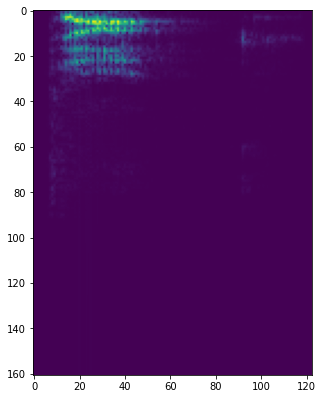

In [274]:
plt.figure(figsize=(5,9))
plt.imshow(spec[:, :123])

In [450]:
audio_spect = parser.parse_audio('../data/own/shiiiit.ogg')
inp = {'X': audio_spect[None], 'lens': np.array([audio_spect.shape[1]])}

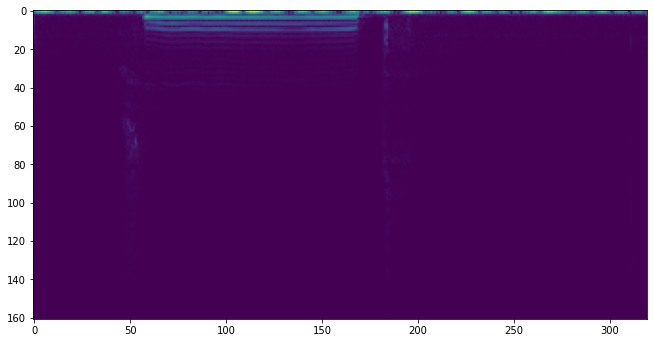

In [451]:
plt.figure(figsize=(11, 9))
plt.imshow(audio_spect[:, :audio_spect.shape[1]])

In [286]:
from deepspeech.data.data_loader import load_audio
import librosa

In [292]:
def parse_audio_stream(self, y):
    n_fft = int(self.sample_rate * self.window_size)
    win_length = n_fft
    hop_length = int(self.sample_rate * self.window_stride)
    # STFT
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=self.window)
    spect, phase = librosa.magphase(D)
    # S = log(S+1)
    spect = np.log1p(spect)
    spect = torch.FloatTensor(spect)
    if self.normalize:
        mean = spect.mean()
        std = spect.std()
        spect.add_(-mean)
        spect.div_(std)
    return spect

In [312]:
audio_stream = load_audio('../data/own/shiiiit.ogg')

In [512]:
def lowpass(x, a):
    y = x.copy()
    y[0] = a * x[0]
    for i in range(1, len(x)):
        y[i] = (1-a) * y[i-1] + a * x[i]
    return y

In [400]:
def highpass(x, a):
    y = x.copy()
    for i in range(1, len(x) - 1):
        y[i] = a * (y[i-1] + x[i] - x[i-1])
    return y

In [468]:
def highpass_freq(x, fc, sampling_rate):
    a = 1 / (2*np.pi*(1/sampling_rate)*fc + 1)
    return highpass(x, a)

In [609]:
y, sr = librosa.load('../data/forvo/download/duck_13.mp3', sr=16e3)
y.shape, sr

/home/nemo/envs/noswear/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


((8778,), 16000.0)

In [611]:
y = load_audio('../data/forvo/download/duck_13.mp3')
y.shape

(23020,)

In [593]:
from scipy import signal

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=1):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [594]:
audio_inp_filtered = highpass_freq(audio_stream, 1000, sampling_rate=16e3)
audio_inp_filtered = butter_highpass_filter(audio_stream, 300, 16e3)
audio_spect_filtered = parse_audio_stream(parser, audio_inp_filtered)

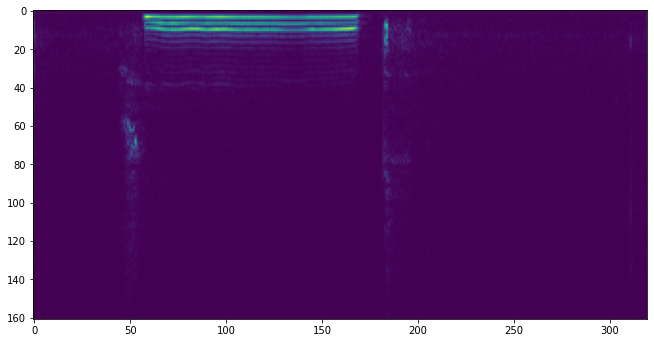

In [595]:
plt.figure(figsize=(11, 9))
plt.imshow(audio_spect_filtered[:, :audio_spect_filtered.shape[1]])

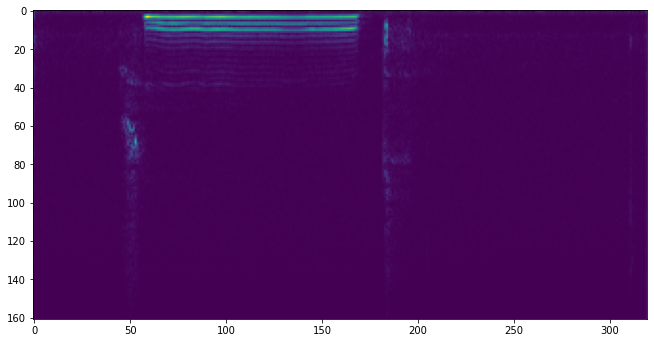

In [583]:
plt.figure(figsize=(11, 9))
plt.imshow(audio_spect_filtered[:, :audio_spect_filtered.shape[1]])

In [567]:
inp = {'X': audio_spect[None], 'lens': np.array([audio_spect.shape[1]])}
net.predict(inp)

array([0], dtype=uint8)

In [579]:
inp_filtered = {'X': audio_spect_filtered[None], 'lens': np.array([audio_spect_filtered.shape[1]])}
net.predict(inp_filtered)

array([1], dtype=uint8)

In [569]:
c, i, ics, hX, cX = zip(*list(net.forward_iter(inp)))

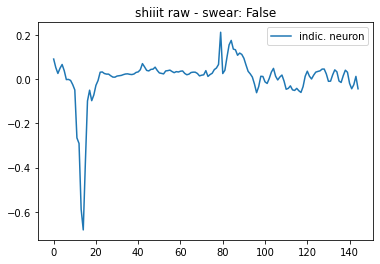

In [465]:
plot_seq_base(ics[0][0], c[0].item(), fpath='shiiit raw')

In [596]:
c, i, ics, hX, cX = zip(*list(net.forward_iter(inp_filtered)))

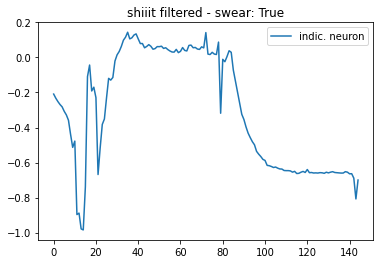

In [597]:
plot_seq_base(ics[0][0], c[0].item(), fpath='shiiit filtered')

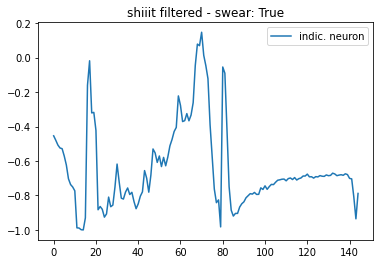

In [467]:
plot_seq_base(ics[0][0], c[0].item(), fpath='shiiit filtered')

In [200]:
net.predict(X_slable[4:5])

array([0], dtype=uint8)

Let's inspect the indicator neuron (what does it do)

In [22]:
outputs = list(net.forward_iter(X_train))

It seems to strongly, inversely correlate with the predicted output class

In [27]:
class_log, indicator_log, indicator_sequence_log = zip(*outputs)
class_log = torch.cat(class_log)
indicator_log = torch.cat(indicator_log)

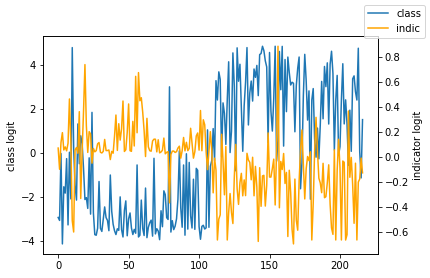

In [28]:
plt.plot(class_log)
plt.ylabel('class logit')

ax = plt.twinx()
ax.plot(indicator_log, c='orange')
plt.ylabel('indicator logit')

plt.gcf().legend(['class', 'indic']);

How does it evolve in time?

In [406]:
indicator_sequences = debatch_indicator_sequences(outputs)

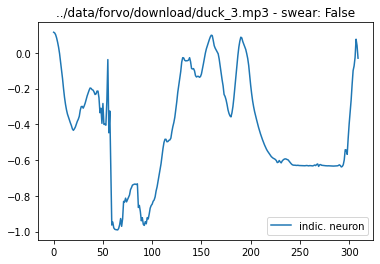

In [408]:
plot_seq(0)

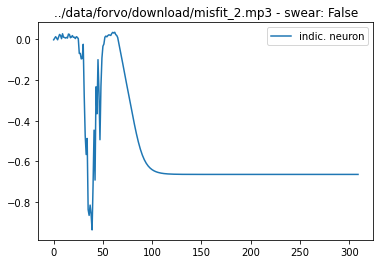

In [409]:
plot_seq(2)

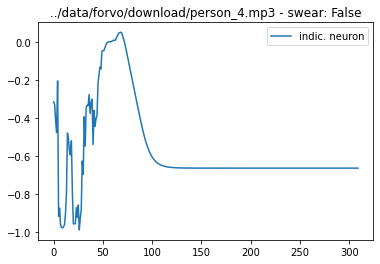

In [410]:
plot_seq(3)

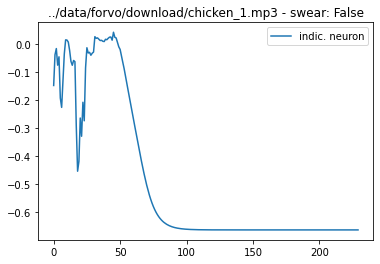

In [411]:
plot_seq(4)

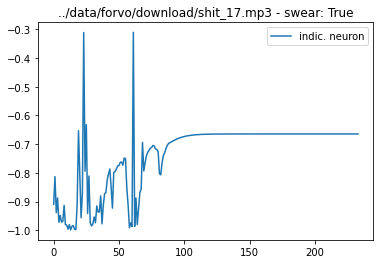

In [412]:
plot_seq(20)

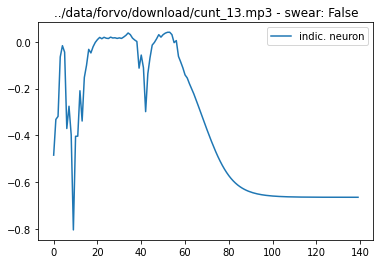

In [413]:
plot_seq(27)

Test on a single sample, a long-stretched 'shiiit'

In [414]:
audio_inp = parser.parse_audio('../data/own/shiiiit.ogg')
inp = {'X': audio_inp[None], 'lens': np.array([audio_inp.shape[1]])}

In [415]:
c, i, ics = zip(*list(net.forward_iter(inp)))

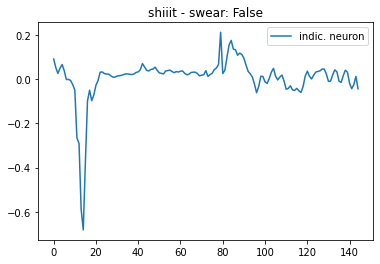

In [416]:
plot_seq_base(ics[0][0], c[0].item(), fpath='shiiit')

### grid search



In [ ]:
from sklearn.model_selection import GridSearchCV
from skorch.helper import SliceDict

In [ ]:
#net.initialize();
net.set_params(verbose=False);

In [ ]:
params = {
    'optimizer__lr': [0.02, 0.002, 0.0002],
    'optimizer__weight_decay': [0, 1e-4],
    'optimizer': [torch.optim.RMSprop, torch.optim.Adam],
    'module__p_dropout': [0, 0.5],
    'module__n_hidden': [10, 100, 200, 400],
    'module__n_layer': [1, 2],
}

In [ ]:
cv = TODO

In [ ]:
gs = GridSearchCV(net, params, scoring='accuracy', cv=cv)

In [ ]:
%%time
gs.fit(SliceDict(**X_train), y_train);

In [ ]:
import pandas as pd
results = pd.DataFrame(gs.cv_results_)

In [ ]:
top_results = results.sort_values(by='mean_test_score').head(10)

In [ ]:
top_results

In [ ]:
top_results.params

In [ ]:
net.set_params(verbose=True, **top_results.params.iloc[1]);

In [ ]:
net.fit(X_train, y_train);

In [ ]:
accuracy_score(y_test, net.predict(X_test))